In [31]:
import torch
import numpy as np
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding, FCEmbedding
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils import BoxUniform
from sbi import analysis

import torch.nn as nn

from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis

from scipy.fft import rfft, rfftfreq
from scipy.stats import entropy

from scipy.signal import savgol_filter

from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

import matplotlib.pyplot as plt

In [32]:
# Generate random input signal
num_simulations = 100000
num_samples = 100
t_max = 10
num_timesteps = 64
noise_std = 0.0025

# np.random.seed(4) # unsure if still need this here
seed = 42

# Generate random input signal
x_data = np.abs(np.cumsum(np.random.rand(num_samples, num_timesteps, 1) - 0.5, axis=1))
t_data = np.linspace(0, t_max, num_timesteps)

# Interpolate input signal to match time resolution
t = np.linspace(0, t_max, 500)
input_signal = np.interp(t, t_data, x_data[0, :, 0])

In [33]:
ts, dt = 30.0, 0.1
steps = int(ts / dt)

def amv(theta, tau_sequence=None, noise_std=0.0, seed=None):
    
    if seed is not None:
        np.random.seed(seed)

    Xu, Xuu, Yv, Yvv, Yr, Nv, Nr, Nrr = theta

    m   = 23.8
    Iz   = 1.76
    xg   = 0.046

    Xud  = -2
    Yvd  = -10
    Yrd  = 0
    Nvd  = 0
    Nrd  = -1

    m11 = m - Xud
    m22 = m - Yvd
    m23 = m * xg - Yrd
    m32 = m * xg - Nvd
    m33 = Iz - Nrd
    mt = m22 * m33 - m23 * m32

    a1 = dt * (m - Yvd) / (m - Xud)
    a2 = dt * (m * xg - Yrd) / (m - Xud)
    a3 = (-dt * (Iz - Nrd) * (m - Xud) / mt) + (dt * (m * xg - Yrd) * (m * xg - Yrd) / mt)
    a4 = dt * (m * xg - Yrd) * (Xud - Yvd) / mt
    a5 = (dt * (m * xg - Nvd) * (m - Xud) / mt) - (dt * (m - Yvd) * (m * xg - Yrd) / mt)
    a6 = -dt * (m - Yvd) * (Xud - Yvd) / mt

    b1  = dt * Xu / (m - Xud)
    b2  = dt * Xuu / (m - Xud)
    b3  = (dt * (Iz - Nrd) * Yv / mt) - (dt * (m * xg - Yrd) * Nv / mt)
    b4  = (dt * (Iz - Nrd) * Yr / mt) - (dt * (m * xg - Yrd) * Nr / mt)
    b5  = dt * (Iz - Nrd) * Yvv / mt
    b6  = -dt * (m * xg - Yrd) * Nrr / mt
    b7  = (dt * (m - Yvd) * Nv / mt) - (dt * (m * xg - Nvd) * Yv / mt)
    b8  = (dt * (m - Yvd) * Nr / mt) - (dt * (m * xg - Nvd) * Yr / mt)
    b9  = -dt * (m * xg - Nvd) * Yvv / mt
    b10 = dt * (m - Yvd) * Nrr / mt

    M = np.array([[m11, 0, 0], [0, m22, m23], [0, m32, m33]])
    B = dt * np.linalg.inv(M)
    
    zeta = np.array([
        a1, a2, b1, b2, a3, a4, b3, b4, b5, b6, a5, a6, b7, b8, b9, b10
    ])

    # Control input (default = fixed)
    if tau_sequence is None:
        tau_sequence = np.tile(np.array([[5, 10, 0]]), (steps, 1))

    # Initial state
    u, v, r = 0.0, 0.0, 0.0
    trajectory = []

    for i in range(steps):
        # Compute nonlinear basis vector f(ν_k)

        u_clamp = np.clip(u, -50, 50)
        v_clamp = np.clip(v, -50, 50)
        r_clamp = np.clip(r, -10, 10)

        f = np.array([
            [v_clamp * r_clamp, r_clamp**2, u_clamp, abs(u_clamp) * u_clamp, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, u_clamp * r_clamp, u_clamp * v_clamp, v_clamp, r_clamp, abs(v_clamp) * v_clamp, abs(r_clamp) * r_clamp, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, u_clamp * r_clamp, u_clamp * v_clamp, v_clamp, r_clamp, abs(v_clamp) * v_clamp, abs(r_clamp) * r_clamp]
        ])

        # Compute state update
        dnu = f @ zeta + (B @ tau_sequence[i].reshape(3, 1)).flatten()

        # Add noise if requested
        if noise_std > 0:
            dnu += np.random.normal(scale=noise_std, size=3)

        # Update state
        u, v, r = u + dnu[0], v + dnu[1], r + dnu[2]

        # Save state
        trajectory.append([u, v, r])

    return torch.tensor(trajectory, dtype=torch.float32)

In [34]:
def random_tau_sequence():
    t = np.linspace(0, ts, steps)
    tau = np.stack([
        5 * np.sin(0.2 * t) + 0.5 * np.random.randn(steps),
        3 * np.cos(0.1 * t) + 0.5 * np.random.randn(steps),
        0.2 * np.sin(0.4 * t)
    ], axis=1)
    return tau

In [35]:

def extract_summary_stats(trajectory: torch.Tensor, dt: float = 0.1):
    data = trajectory.numpy()  # shape (T, 3)
    summaries = []

    for i in range(3):  # for u, v, r
        x = data[:, i]

        # Time-domain features
        mean = np.mean(x)
        std = np.std(x)
        final = x[-1]
        max_val = np.max(x)
        min_val = np.min(x)
        peak_val = np.max(np.abs(x))
        peak_idx = np.argmax(np.abs(x))
        peak_time = peak_idx * dt
        rms = np.sqrt(np.mean(x**2))

        # Step-response features
        initial = x[0]
        overshoot = (max_val - final) / (final + 1e-8) if final != 0 else 0
        settling_time = next((i * dt for i in range(len(x)-1, -1, -1)
                              if abs(x[i] - final) > 0.02 * abs(final)), 0)

        # Frequency-domain (FFT)
        fft_vals = np.abs(rfft(x - np.mean(x)))
        freqs = rfftfreq(len(x), d=dt)
        power = fft_vals**2
        dominant_freq = freqs[np.argmax(power)]
        spectral_power = np.max(power)
        norm_power = power / (np.sum(power) + 1e-8)
        spec_entropy = entropy(norm_power)

        summaries.extend([
            mean, std, final, max_val, min_val,
            peak_val, peak_time, rms,
            dominant_freq, spectral_power, spec_entropy,
            overshoot, settling_time
        ])

    return torch.tensor(summaries, dtype=torch.float32)

In [36]:
def simulator(theta: torch.Tensor, seed=None) -> torch.Tensor:
    trajectory = amv(theta.numpy(), noise_std=noise_std, seed=seed)
    trajectory_smooth = torch.tensor(np.stack([
        savgol_filter(trajectory[:, i], window_length=15, polyorder=3)
        for i in range(trajectory.shape[1])
    ], axis=1), dtype=torch.float32)

    summary = extract_summary_stats(trajectory_smooth)
    return (summary - summary_mean) / (summary_std + 1e-8)

In [37]:
# True parameters
m_true   = 23.8
Iz_true   = 1.76
xg_true   = 0.046

Xud_true  = -2
Yvd_true  = -10
Yrd_true  = 0
Nvd_true  = 0
Nrd_true  = -1

Xu_true   = -0.7225
Xuu_true  = -1.3274
Yv_true   = -0.8612
Yvv_true  = -36.2823
Yr_true   = 0.1079
Nv_true   = 0.1052
Nr_true  = -0.5
Nrr_true = -1

true_params = torch.tensor([Xu_true, Xuu_true, Yv_true, Yvv_true, Yr_true, Nv_true, Nr_true, Nrr_true])

In [38]:
x_obs = amv(true_params.numpy(), noise_std=0)

true_trajectory = torch.tensor(np.stack([
    savgol_filter(x_obs[:, i], window_length=15, polyorder=3)
    for i in range(x_obs.shape[1])
], axis=1))

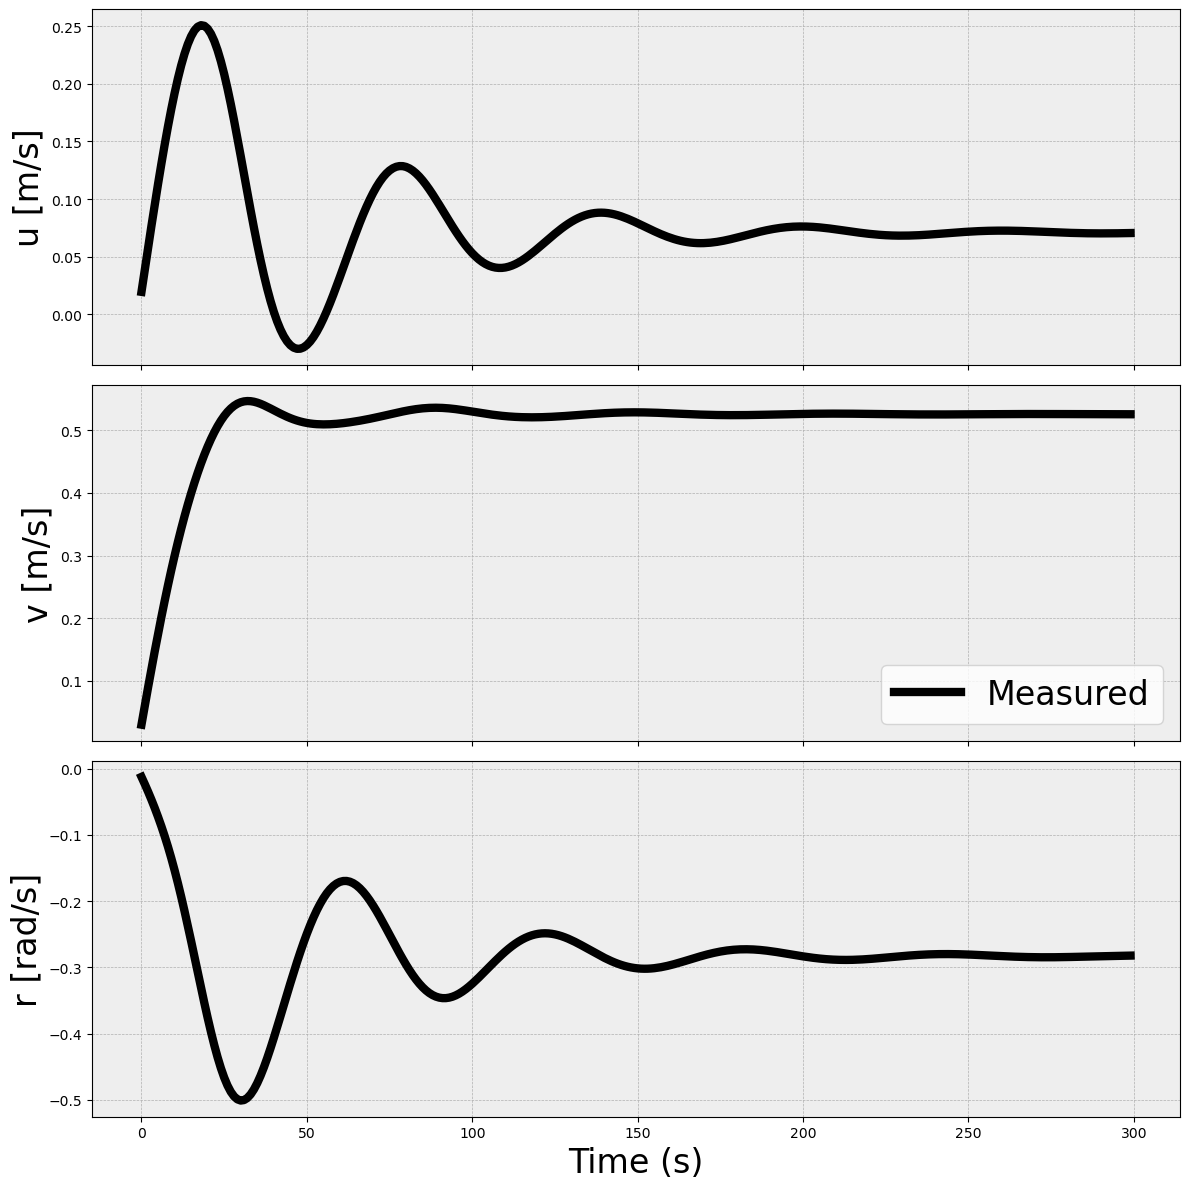

In [39]:
t = torch.arange(true_trajectory.shape[0])

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Define colors
bg_color = '#EEEEEE'
line_width = 6
font_size = 24

# Subplot 1: u [m/s]
axes[0].plot(t, true_trajectory[:, 0], '-k', linewidth=line_width, label='Measured')
axes[0].set_ylabel('u [m/s]', fontsize=font_size)
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[0].set_facecolor(bg_color)

# Subplot 2: v [m/s]
axes[1].plot(t, true_trajectory[:, 1], '-k', linewidth=line_width, label='Measured')
axes[1].set_ylabel('v [m/s]', fontsize=font_size)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].set_facecolor(bg_color)
axes[1].legend(fontsize=font_size)

# Subplot 3: r [rad/s]
axes[2].plot(t, true_trajectory[:, 2], '-k', linewidth=line_width, label='Measured')
axes[2].set_ylabel('r [rad/s]', fontsize=font_size)
axes[2].set_xlabel('Time (s)', fontsize=font_size)
axes[2].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[2].set_facecolor(bg_color)

# Apply general figure settings
plt.tight_layout()
plt.show()

In [40]:
low = torch.tensor([
    -2.0,  # Xu
    -2.0,  # Xuu
    -2.0,  # Yv
    -50.0, # Yvv
    -1.0,  # Yr
    -1.0,  # Nv
    -1.5,  # Nr
    -2.0   # Nrr
])

high = torch.tensor([
    0.0,
    0.0,
    0.5,
    -20.0,
    1.0,
    1.0,
    0.0,
    0.0
])

# low = torch.tensor([
#     -10.0,  # Xu
#     -10.0,  # Xuu
#     -10.0,  # Yv
#     -50.0, # Yvv
#     -10.0,  # Yr
#     -10.0,  # Nv
#     -10.0,  # Nr
#     -10.0   # Nrr
# ])

# high = torch.tensor([
#     10.0,
#     10.0,
#     10.5,
#     10.0,
#     10.0,
#     10.0,
#     10.0,
#     10.0
# ])

In [41]:
prior = BoxUniform(
    low=low,
    high=high
)
prior, num_parameters, prior_returns_numpy = process_prior(prior)

In [42]:
raw_simulator = lambda theta: extract_summary_stats(amv(theta.numpy(), noise_std=noise_std))

theta_batch = prior.sample((1000,))
summaries = torch.stack([raw_simulator(theta) for theta in theta_batch])

summary_mean = summaries.mean(dim=0)
summary_std = summaries.std(dim=0)

In [43]:
simulator_wrapper = process_simulator(simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator_wrapper, prior)

In [44]:
inference = NPE(prior=prior)
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=5)
density_estimator = inference.append_simulations(theta, x).train()

  0%|          | 0/5 [00:00<?, ?it/s]

 Neural network successfully converged after 84 epochs.

In [45]:
posterior = inference.build_posterior(density_estimator)

In [46]:
x_summary_obs = simulator(true_params, seed=seed)


In [ ]:
# Infer parameters
samples = posterior.sample((100000,), x=x_summary_obs)
inferred = samples.mean(dim=0)

print(f"Sampled 0: {true_params[0]}, {inferred[0]}")
print(f"Sampled 1: {true_params[1]}, {inferred[1]}")
print(f"Sampled 2: {true_params[2]}, {inferred[2]}")
print(f"Sampled 3: {true_params[3]}, {inferred[3]}")
print(f"Sampled 4: {true_params[4]}, {inferred[4]}")
print(f"Sampled 5: {true_params[5]}, {inferred[5]}")
print(f"Sampled 6: {true_params[6]}, {inferred[6]}")
print(f"Sampled 7: {true_params[7]}, {inferred[7]}")

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

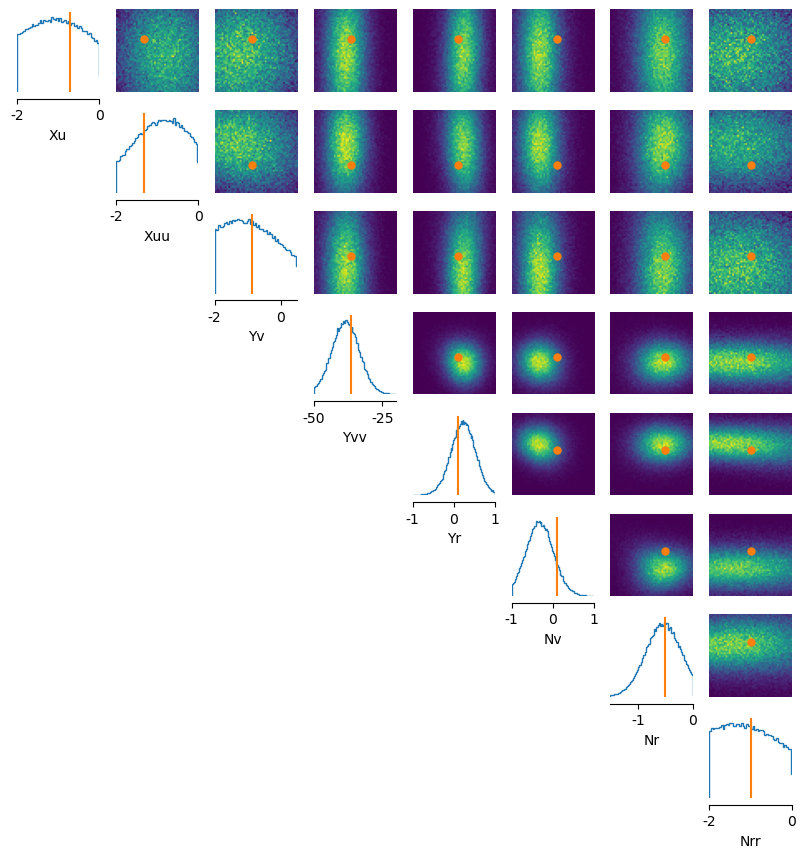

In [28]:
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]
labels=['Xu', 'Xuu', 'Yv', 'Yvv', 'Yr', 'Nv', 'Nr', 'Nrr']

fig, ax = analysis.pairplot(
    samples,
    points=true_params,
    labels=labels,
    limits=limits,
)

In [29]:
def plot_posterior_prediction_band_amv(
    posterior,
    x_o,
    simulator_raw,
    true_trajectory,
    num_samples=100,
    show_samples=False,
    color='C0',
    label='Posterior Predictive',
    seed=None
):
    import matplotlib.pyplot as plt
    import numpy as np

    u_traj, v_traj, r_traj = [], [], []
    t_ref = None

    theta_samples = posterior.sample((num_samples,), x=x_o).numpy()
    for theta in theta_samples:
        trajectory = simulator_raw(theta, noise_std=0.0, seed=seed)
        if t_ref is None:
            t_ref = np.linspace(0, trajectory.shape[0]*0.1, trajectory.shape[0])
        u_traj.append(trajectory[:, 0].numpy())
        v_traj.append(trajectory[:, 1].numpy())
        r_traj.append(trajectory[:, 2].numpy())

    u_traj = np.stack(u_traj)
    v_traj = np.stack(v_traj)
    r_traj = np.stack(r_traj)

    def plot_band(data, t, base_color, variable_name):
        quantiles = [50, 70, 90]
        alphas = [0.25, 0.18, 0.12]
        for q, alpha in zip(quantiles, alphas):
            lower = np.percentile(data, 50 - q/2, axis=0)
            upper = np.percentile(data, 50 + q/2, axis=0)
            plt.fill_between(t, lower, upper, color=base_color, alpha=alpha,
                             label=f'{label} {variable_name} ({q}% CI)' if q == 90 else None)
        median = np.median(data, axis=0)
        plt.plot(t, median, color=base_color, lw=2, label=f'{label} {variable_name} (Median)')
        if show_samples:
            for traj in data:
                plt.plot(t, traj, color=base_color, alpha=0.05, lw=0.5)

    plt.figure(figsize=(12, 10))

    plt.subplot(3, 1, 1)
    plot_band(u_traj, t_ref, 'C0', '$u$ [m/s]')
    plt.plot(t_ref, true_trajectory[:, 0].numpy(), '--k', label='True $u$', linewidth=2)
    plt.ylabel("u [m/s]")
    plt.grid()

    plt.subplot(3, 1, 2)
    plot_band(v_traj, t_ref, 'C1', '$v$ [m/s]')
    plt.plot(t_ref, true_trajectory[:, 1].numpy(), '--r', label='True $v$', linewidth=2)
    plt.ylabel("v [m/s]")
    plt.grid()

    plt.subplot(3, 1, 3)
    plot_band(r_traj, t_ref, 'C2', '$r$ [rad/s]')
    plt.plot(t_ref, true_trajectory[:, 2].numpy(), '--g', label='True $r$', linewidth=2)
    plt.ylabel("r [rad/s]")
    plt.xlabel("Time [s]")
    plt.grid()

    plt.tight_layout()
    plt.legend()
    plt.show()

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

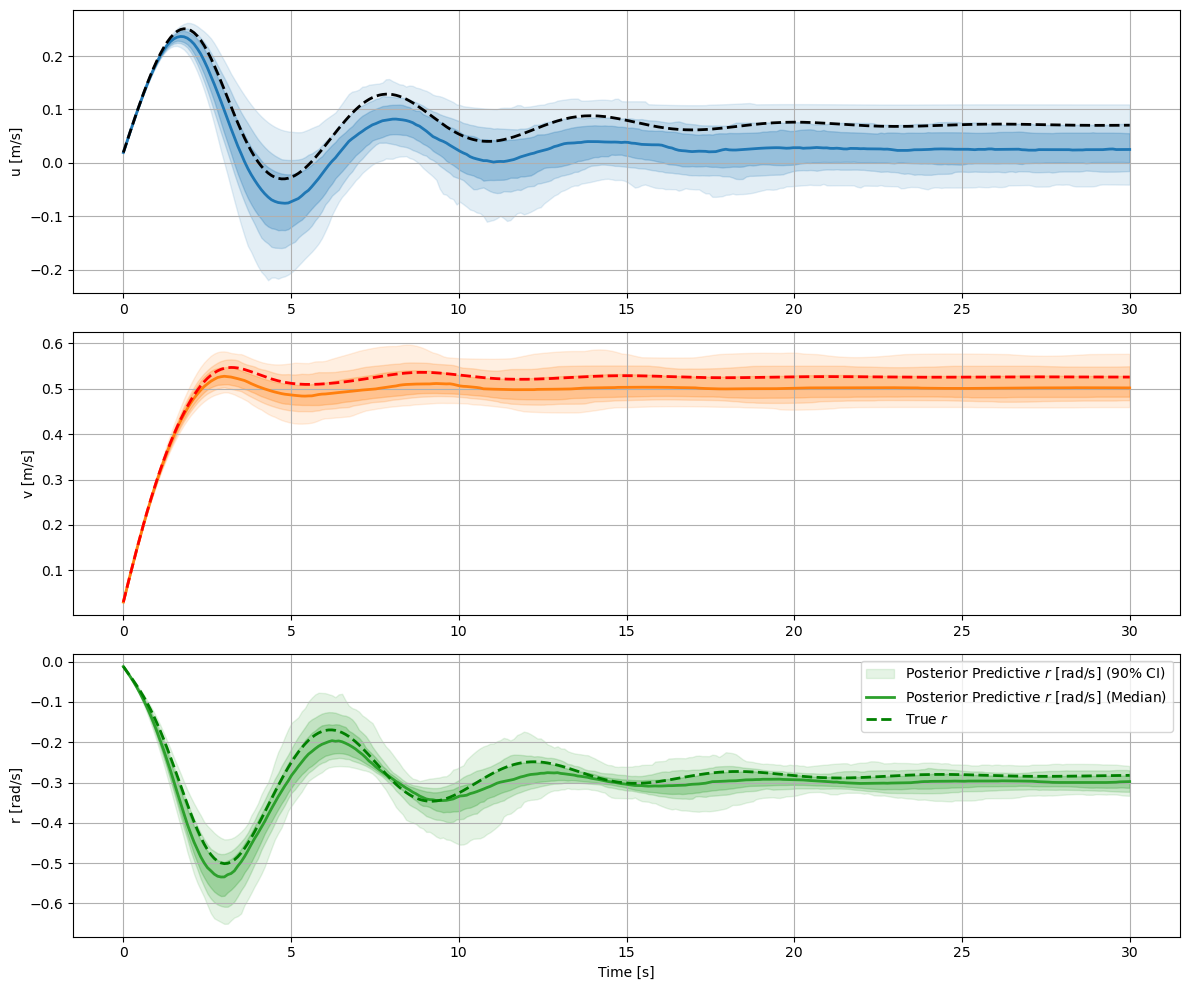

In [30]:
plot_posterior_prediction_band_amv(
    posterior,
    x_summary_obs,
    true_trajectory=x_obs,
    simulator_raw=amv,
    num_samples=200,
    show_samples=False,
    seed=seed
)

In [ ]:
class LSTMEmbedding(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, output_size=16, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,  # 3 = u, v, r
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.output_net = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [B, T, C]
        _, (hn, _) = self.lstm(x)
        return self.output_net(hn[-1])

In [ ]:
class HybridEmbedding(nn.Module):
    def __init__(self, seq_embed_net, stats_dim=39, seq_channels=3, seq_len=300, fused_dim=16):
        super().__init__()
        self.seq_embed_net = seq_embed_net
        self.seq_shape = (seq_channels, seq_len)
        self.stats_dim = stats_dim

        self.stats_fc = nn.Sequential(
            nn.Linear(stats_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.fusion = nn.Sequential(
            nn.Linear(16 + fused_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):  # x: [B, 3*300 + 39]
        seq_flat = x[:, :-self.stats_dim]
        stats = x[:, -self.stats_dim:]

        seq = seq_flat.view(x.shape[0], *self.seq_shape)
        seq_embed = self.seq_embed_net(seq)
        stats_embed = self.stats_fc(stats)

        return self.fusion(torch.cat([seq_embed, stats_embed], dim=1))

In [ ]:
def amv_hybrid(theta: torch.Tensor) -> torch.Tensor:
    # Trajectory
    trajectory = amv(theta.numpy(), noise_std=0.0025)

    # Smooth
    trajectory_smooth = torch.tensor(np.stack([
        savgol_filter(trajectory[:, i], window_length=15, polyorder=3)
        for i in range(trajectory.shape[1])
    ], axis=1), dtype=torch.float32)

    sequence = trajectory_smooth.T  # [3, steps]
    
    # Summary stats (normalized)
    stats = extract_summary_stats(trajectory_smooth)
    stats_norm = (stats - summary_mean) / (summary_std + 1e-8)

    # Flatten hybrid vector
    hybrid_vector = torch.cat([sequence.flatten(), stats_norm])
    return hybrid_vector

In [ ]:
embedding_net = HybridEmbedding(
    seq_embed_net=LSTMEmbedding(input_size=3),
    stats_dim=39,
    seq_channels=3,
    seq_len=steps
)

In [ ]:
density_estimator = posterior_nn(model='maf', embedding_net=embedding_net)

In [ ]:
inference = NPE(prior=prior, density_estimator=density_estimator)

In [ ]:
simulator_wrapper = process_simulator(amv_hybrid, prior, prior_returns_numpy)
check_sbi_inputs(simulator_wrapper, prior)

In [ ]:
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)

In [ ]:
density_estimator = inference.append_simulations(theta, x).train()

In [ ]:
posterior = inference.build_posterior()

In [ ]:
import pickle
with open(f"./models/amv_hybrid_{num_simulations}.pkl", "wb") as handle:
    pickle.dump(posterior, handle)

In [ ]:
x_summary_obs = amv_hybrid(true_params)
samples = posterior.sample((5000,), x=x_summary_obs)

In [ ]:
observed_data_2 = simulator(true_params)
# Infer parameters
samples_2 = posterior.sample((100000,), x=x_summary_obs)
m_inferred_2 = samples_2.mean(dim=0)


print(f"Sampled 0: {true_params[0]}, {m_inferred_2[0]}")
print(f"Sampled 1: {true_params[1]}, {m_inferred_2[1]}")
print(f"Sampled 2: {true_params[2]}, {m_inferred_2[2]}")
print(f"Sampled 3: {true_params[3]}, {m_inferred_2[3]}")
print(f"Sampled 4: {true_params[4]}, {m_inferred_2[4]}")
print(f"Sampled 5: {true_params[5]}, {m_inferred_2[5]}")
print(f"Sampled 6: {true_params[6]}, {m_inferred_2[6]}")
print(f"Sampled 7: {true_params[7]}, {m_inferred_2[7]}")

In [ ]:
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]
labels=['Xu', 'Xuu', 'Yv', 'Yvv', 'Yr', 'Nv', 'Nr', 'Nrr']

fig, ax = analysis.pairplot(
    samples_2,
    points=true_params,
    labels=labels,
    limits=limits,
)

In [ ]:
trajectory = amv(true_params, noise_std=0.0025)
# x_o = extract_summary_stats(trajectory)

# x_o = amv_hybrid

plot_posterior_prediction_band_amv(
    posterior,
    x_summary_obs,
    simulator_raw=amv,
    num_samples=200,
    show_samples=False
)

In [ ]:
hidden_sizes = [64, 128]
output_sizes = [8, 16, 32]
num_layers_list = [1, 2]

learning_rates = [1e-4, 5e-4, 1e-3]
batch_sizes = [64, 128, 256]
num_simulations_list = [10000, 50000, 100000]

In [ ]:
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]
labels=['Xu', 'Xuu', 'Yv', 'Yvv', 'Yr', 'Nv', 'Nr', 'Nrr']

In [ ]:
trajectory = amv(true_params.numpy(), noise_std=0.0025)
trajectory_smooth = torch.tensor(np.stack([
    savgol_filter(trajectory[:, i], window_length=15, polyorder=3)
    for i in range(trajectory.shape[1])
], axis=1), dtype=torch.float32)

sequence = trajectory_smooth.T
summary = extract_summary_stats(trajectory_smooth)
summary_norm = (summary - summary_mean) / (summary_std + 1e-8)

x_summary_obs_norm = torch.cat([sequence.flatten(), summary_norm])

In [ ]:
results = []

for hidden_size in hidden_sizes:
    for output_size in output_sizes:
        for num_layers in num_layers_list:
            for learning_rate in learning_rates:
                for num_simulations in num_simulations_list:
                    print(f"\n🔧 Trying num_simulations={num_simulations} hidden={hidden_size}, output={output_size}, layers={num_layers} learning_rate={learning_rate}")

                    # Create LSTM and hybrid embedding
                    lstm = LSTMEmbedding(
                        input_size=3,
                        hidden_size=hidden_size,
                        output_size=output_size,
                        num_layers=num_layers
                    )
                    embedding_net = HybridEmbedding(
                        seq_embed_net=lstm,
                        stats_dim=39,
                        seq_channels=3,
                        seq_len=steps,
                        fused_dim=output_size
                    )

                    # Set up SBI
                    density_estimator = posterior_nn(model="maf", embedding_net=embedding_net)
                    inference = NPE(prior=prior, density_estimator=density_estimator)

                    # Sample training data
                    theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10000)

                    # Train posterior
                    density_estimator = inference.append_simulations(theta, x).train(learning_rate=learning_rate)
                    posterior = inference.build_posterior()

                    with open(f"./models/amv_hybrid_{num_simulations}-{hidden_size}-{output_size}-{num_layers}-{learning_rate}.pkl", "wb") as handle:
                        pickle.dump(posterior, handle)

                    # Evaluate
                    samples = posterior.sample((5000,), x=x_summary_obs_norm)
                    inferred_mean = samples.mean(0)
                    mse = ((inferred_mean - true_params) ** 2).mean().item()
                    squared_errors = (inferred_mean - true_params) ** 2
                    for i, err in enumerate(squared_errors):
                        print(f"Param {i}: squared error = {err.item():.5f}")

                    print(f"✅ MSE = {mse:.5f}")

                    fig, ax = analysis.pairplot(
                        samples_2,
                        points=true_params,
                        labels=labels,
                        limits=limits,
                    )

                    results.append({
                        "hidden_size": hidden_size,
                        "output_size": output_size,
                        "num_layers": num_layers,
                        "squared_errors": squared_errors,
                        "mse": mse
                    })